- change validation to adapt to real evaluation system
- completely change the programs of feature engineering to prevent leakage and make it efficient
- add listening and reading accuracy

In [1]:
import sys
import copy
import random
import feather
import warnings
import numpy as np
import pandas as pd
from time import time
import lightgbm as lgb
from collections import Counter
from sklearn import preprocessing
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt 

import riiideducation
warnings.filterwarnings("ignore")

In [2]:
DIR = "../input/riiid-test-answer-prediction/"
train = pd.read_feather("../input/riid-train/train.feather")
lectures = pd.read_csv(DIR+"lectures.csv")
questions = pd.read_csv(DIR+"questions.csv")
example_test = pd.read_csv(DIR+"example_test.csv")

# preprocess

In [3]:
train.drop(["row_id", 'user_answer'], axis=1, inplace=True)
train = train.loc[train['answered_correctly'] != -1].reset_index(drop=True)
# https://stackoverflow.com/questions/25888207/pandas-join-dataframes-on-field-with-different-names
train = train.merge(questions[["question_id", "part"]], how="left", left_on=['content_id'], right_on=['question_id'])
train.drop(["question_id"], axis=1, inplace=True)
train = train.sort_values(['user_id', 'timestamp'])
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].fillna(value = False).astype(bool)

user_answers_df = train.groupby('user_id').agg({'answered_correctly': ['mean']}).copy()
user_answers_df.columns = ["acc_before_ans"]

user_answers_past2 = pd.DataFrame(train.groupby("user_id").tail(2).groupby("user_id").agg("mean")["answered_correctly"])
user_answers_past2.columns = ["mean_of_last_2_acc_by_user_id"]
user_answers_past3 = pd.DataFrame(train.groupby("user_id").tail(3).groupby("user_id").agg("mean")["answered_correctly"])
user_answers_past3.columns = ["mean_of_last_3_acc_by_user_id"]

user_part_accuracy = train.groupby(['user_id', 'part']).agg({'answered_correctly': ['mean']}).copy().unstack()
user_part_accuracy.columns = ["part1_acc", "part2_acc", "part3_acc", "part4_acc", "part5_acc", "part6_acc", "part7_acc"]

mean_accuracy_by_part = np.array([0.74503238, 0.70869406, 0.70145593, 0.63099758, 0.61008792, 0.66938835, 0.65960112])

tmp1 = pd.DataFrame(train.groupby(['user_id', 'part']).agg({'answered_correctly': ['count']}).unstack())
tmp1.columns = [1,2,3,4,5,6,7]
tmp1["read"], tmp1["listen"] = tmp1.iloc[:,4:].sum(axis=1), tmp1.iloc[:,:4].sum(axis=1)
tmp1.drop([1,2,3,4,5,6,7], axis=1,inplace=True)

mean_accuracy_by_user_sec = pd.DataFrame(train.groupby(['user_id', 'part']).agg({'answered_correctly': ['sum']}).unstack())
mean_accuracy_by_user_sec.columns = [1,2,3,4,5,6,7]
mean_accuracy_by_user_sec["read_acc"] = mean_accuracy_by_user_sec.iloc[:,4:].sum(axis=1)
mean_accuracy_by_user_sec["listen_acc"] = mean_accuracy_by_user_sec.iloc[:,:4].sum(axis=1)
mean_accuracy_by_user_sec.drop([1,2,3,4,5,6,7], axis=1,inplace=True)
mean_accuracy_by_user_sec["read_acc"] /= tmp1["read"]
mean_accuracy_by_user_sec["listen_acc"] /= tmp1["listen"]

del tmp1

In [4]:
le = preprocessing.LabelEncoder()
train["prior_question_had_explanation"] = le.fit_transform(train["prior_question_had_explanation"])

In [5]:
train = train.iloc[90007298:,:]
train = train.sort_values(['user_id', 'timestamp'])
train['task_container_id'] = (train.groupby('user_id')['task_container_id'].transform(lambda x: pd.factorize(x)[0]).astype('int16'))
print(train.shape, len(train.user_id.unique()))
train.head(10)

(9264002, 9) 36706


,timestamp,user_id,content_id,content_type_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,part
90007298,1796340048,1947975793,6603,0,0,1,20500,1,6
90007299,1796340048,1947975793,6601,0,0,1,20500,1,6
90007300,1796340048,1947975793,6602,0,0,1,20500,1,6
90007301,1796438940,1947975793,10076,0,1,1,6000,1,6
90007302,1796438940,1947975793,10077,0,1,0,6000,1,6
90007303,1796438940,1947975793,10075,0,1,0,6000,1,6
90007304,1796438940,1947975793,10074,0,1,0,6000,1,6
90007305,1796775843,1947975793,10075,0,2,0,22750,1,6
90007306,1796775843,1947975793,10076,0,2,1,22750,1,6
90007307,1796775843,1947975793,10074,0,2,0,22750,1,6


# Feature engineering

In [6]:
%%time
def get_data(df, test_set=False):
    if test_set == False:
        
        # cumsum correct answer by user_id
        tmp1 = df.groupby(['user_id'])['answered_correctly'].apply(lambda x: pd.concat([pd.DataFrame([0]), x.cumsum()[:-1]])).reset_index(drop=True).values
        # cumsum total try by user_id
        tmp2 = df.groupby(['user_id']).cumcount().values 
        correct_rate = [(tmp1[i]/tmp2[i])[0] if tmp2[i] != 0 else -1 for i in range(len(tmp1))]
        
        # cumsum of each part trial by user
        part1_cumsum = df.groupby(["user_id"])['part'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part2_cumsum = df.groupby(["user_id"])['part'].apply(lambda x: pd.DataFrame([0] + (x==2).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part3_cumsum = df.groupby(["user_id"])['part'].apply(lambda x: pd.DataFrame([0] + (x==3).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part4_cumsum = df.groupby(["user_id"])['part'].apply(lambda x: pd.DataFrame([0] + (x==4).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part5_cumsum = df.groupby(["user_id"])['part'].apply(lambda x: pd.DataFrame([0] + (x==5).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part6_cumsum = df.groupby(["user_id"])['part'].apply(lambda x: pd.DataFrame([0] + (x==6).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part7_cumsum = df.groupby(["user_id"])['part'].apply(lambda x: pd.DataFrame([0] + (x==7).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values

        # logical bool if part is matched by user
        part1_g = pd.DataFrame(df.groupby(["user_id"])['part'].apply(lambda x: x==1))
        part2_g = pd.DataFrame(df.groupby(["user_id"])['part'].apply(lambda x: x==2))
        part3_g = pd.DataFrame(df.groupby(["user_id"])['part'].apply(lambda x: x==3))
        part4_g = pd.DataFrame(df.groupby(["user_id"])['part'].apply(lambda x: x==4))
        part5_g = pd.DataFrame(df.groupby(["user_id"])['part'].apply(lambda x: x==5))
        part6_g = pd.DataFrame(df.groupby(["user_id"])['part'].apply(lambda x: x==6))
        part7_g = pd.DataFrame(df.groupby(["user_id"])['part'].apply(lambda x: x==7))
        # logical bool if answer is correct by user
        acc_g = pd.DataFrame(df.groupby(["user_id"])['answered_correctly'].apply(lambda x: x==1))

        # cumsum of correct num per part by user
        part1_acc_cumsum = np.logical_and(acc_g.values ,part1_g.values)
        part2_acc_cumsum = np.logical_and(acc_g.values ,part2_g.values)
        part3_acc_cumsum = np.logical_and(acc_g.values ,part3_g.values)
        part4_acc_cumsum = np.logical_and(acc_g.values ,part4_g.values)
        part5_acc_cumsum = np.logical_and(acc_g.values ,part5_g.values)
        part6_acc_cumsum = np.logical_and(acc_g.values ,part6_g.values)
        part7_acc_cumsum = np.logical_and(acc_g.values ,part7_g.values)
                        
        listen_cumsum = part1_cumsum + part2_cumsum  + part3_cumsum + part4_cumsum
        read_cumsum = part5_cumsum + part6_cumsum  + part7_cumsum
        
        listen_g = np.logical_or(np.logical_or(part1_g.values, part2_g.values, part3_g.values), part4_g.values)
        read_g = np.logical_or(part5_g.values, part6_g.values, part7_g.values)
        
        listen_acc_cumsum = np.logical_and(acc_g.values ,listen_g)
        read_acc_cumsum = np.logical_and(acc_g.values ,read_g)

        df["part1_and_ok"] = part1_acc_cumsum
        df["part2_and_ok"] = part2_acc_cumsum
        df["part3_and_ok"] = part3_acc_cumsum
        df["part4_and_ok"] = part4_acc_cumsum 
        df["part5_and_ok"] = part5_acc_cumsum
        df["part6_and_ok"] = part6_acc_cumsum
        df["part7_and_ok"] = part7_acc_cumsum
        df["read_and_ok"] = read_acc_cumsum
        df["listen_and_ok"] = listen_acc_cumsum
        
        part1_acc_cumsum = df.groupby(["user_id"])['part1_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part2_acc_cumsum = df.groupby(["user_id"])['part2_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part3_acc_cumsum = df.groupby(["user_id"])['part3_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part4_acc_cumsum = df.groupby(["user_id"])['part4_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part5_acc_cumsum = df.groupby(["user_id"])['part5_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part6_acc_cumsum = df.groupby(["user_id"])['part6_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        part7_acc_cumsum = df.groupby(["user_id"])['part7_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        read_acc_cumsum = df.groupby(["user_id"])['read_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values
        listen_acc_cumsum = df.groupby(["user_id"])['listen_and_ok'].apply(lambda x: pd.DataFrame([0] + (x==1).cumsum().tolist()[:-1])).reset_index(drop=True)[0].values

        part1_acc_rate = [part1_acc_cumsum[i] / part1_cumsum[i] if part1_cumsum[i] != 0 else -1 for i in range(len(part1_cumsum))]
        part2_acc_rate = [part2_acc_cumsum[i] / part2_cumsum[i] if part2_cumsum[i] != 0 else -1 for i in range(len(part2_cumsum))]
        part3_acc_rate = [part3_acc_cumsum[i] / part3_cumsum[i] if part3_cumsum[i] != 0 else -1 for i in range(len(part3_cumsum))]
        part4_acc_rate = [part4_acc_cumsum[i] / part4_cumsum[i] if part4_cumsum[i] != 0 else -1 for i in range(len(part4_cumsum))]
        part5_acc_rate = [part5_acc_cumsum[i] / part5_cumsum[i] if part5_cumsum[i] != 0 else -1 for i in range(len(part5_cumsum))]
        part6_acc_rate = [part6_acc_cumsum[i] / part6_cumsum[i] if part6_cumsum[i] != 0 else -1 for i in range(len(part6_cumsum))]
        part7_acc_rate = [part7_acc_cumsum[i] / part7_cumsum[i] if part7_cumsum[i] != 0 else -1 for i in range(len(part7_cumsum))]
        read_acc_rate = [read_acc_cumsum[i] / read_cumsum[i] if read_cumsum[i] != 0 else -1 for i in range(len(read_cumsum))]
        listen_acc_rate = [listen_acc_cumsum[i] / listen_cumsum[i] if listen_cumsum[i] != 0 else -1 for i in range(len(listen_cumsum))]  
                    
        df["acc_before_ans"] = correct_rate
        df["part1_acc"] = part1_acc_rate
        df["part2_acc"] = part2_acc_rate
        df["part3_acc"] = part3_acc_rate
        df["part4_acc"] = part4_acc_rate
        df["part5_acc"] = part5_acc_rate
        df["part6_acc"] = part6_acc_rate
        df["part7_acc"] = part7_acc_rate
        df["read_acc"] = read_acc_rate
        df["listen_acc"] = listen_acc_rate
        
    else:
        df = df.merge(user_answers_df, how = 'left', on = 'user_id') # for acc_before_ans
        df = df.merge(user_part_accuracy, how = 'left', on = 'user_id')
        df = df.merge(user_answers_past2, how = 'left', on = 'user_id')
        df = df.merge(user_answers_past3, how = 'left', on = 'user_id')
        df = df.merge(mean_accuracy_by_user_sec, how = 'left', on = 'user_id')

    df.drop(["timestamp"], axis=1, inplace=True)
    df.fillna(value = -1, inplace = True)
    return df
train = get_data(train)

CPU times: user 17min 51s, sys: 20.4 s, total: 18min 11s
Wall time: 18min 8s


In [7]:
# target encoding + moving average not to cause target leakage
AGGS = [
    ('answered_correctly', 2, ['user_id'], ['mean']),
    ('answered_correctly', 3, ['user_id'], ['mean']),
]

for on, lag, by, hows in AGGS:
    agg = train.groupby(by)[on].apply(lambda x: (
        x.shift(1).rolling(window=lag, min_periods=1).agg(hows)
    ))
    agg = agg.rename(columns={
        how: f'{how}_of_last_{lag}_acc_by_' + '_and_'.join(by)
        for how in hows
    })

    train = train.join(agg)

In [8]:
target = 'answered_correctly'
columns = ["acc_before_ans", 'content_id', 'part','prior_question_had_explanation', 'prior_question_elapsed_time',
          "part1_acc",  "part2_acc", "part3_acc", "part4_acc", "part5_acc", "part6_acc", "part7_acc",
           "mean_of_last_2_acc_by_user_id", "mean_of_last_3_acc_by_user_id","read_acc", "listen_acc"]
others = ['task_container_id', "user_id"]

drop_columns = [i for i in train.columns if i not in columns + [target] + others]
train.drop(drop_columns, axis=1, inplace=True)

In [9]:
train

,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,part,acc_before_ans,part1_acc,part2_acc,part3_acc,part4_acc,part5_acc,part6_acc,part7_acc,read_acc,listen_acc,mean_of_last_2_acc_by_user_id,mean_of_last_3_acc_by_user_id
90007298,1947975793,6603,0,1,20500,1,6,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.0,-1.0,-1.000000,-1.0,NaN,NaN
90007299,1947975793,6601,0,1,20500,1,6,1.000000,-1.0,-1.0,-1.0,-1.0,-1.000000,1.0,-1.0,1.000000,-1.0,1.0,1.000000
90007300,1947975793,6602,0,1,20500,1,6,1.000000,-1.0,-1.0,-1.0,-1.0,-1.000000,1.0,-1.0,1.000000,-1.0,1.0,1.000000
90007301,1947975793,10076,1,1,6000,1,6,1.000000,-1.0,-1.0,-1.0,-1.0,-1.000000,1.0,-1.0,1.000000,-1.0,1.0,1.000000
90007302,1947975793,10077,1,0,6000,1,6,1.000000,-1.0,-1.0,-1.0,-1.0,-1.000000,1.0,-1.0,1.000000,-1.0,1.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99271295,2147482888,3586,22,1,18000,1,5,0.500000,1.0,-1.0,-1.0,-1.0,0.476190,-1.0,-1.0,0.476190,1.0,1.0,1.000000
99271296,2147482888,6341,23,1,14000,1,5,0.521739,1.0,-1.0,-1.0,-1.0,0.500000,-1.0,-1.0,0.500000,1.0,1.0,1.000000
99271297,2147482888,4212,24,1,14000,1,5,0.541667,1.0,-1.0,-1.0,-1.0,0.521739,-1.0,-1.0,0.521739,1.0,1.0,1.000000
99271298,2147482888,6343,25,0,22000,1,5,0.560000,1.0,-1.0,-1.0,-1.0,0.541667,-1.0,-1.0,0.541667,1.0,1.0,1.000000


# modelling

In [10]:
def sample_scheduler_func(current_lr, eval_history, best_round, current_round, is_higher_better):
    """次のラウンドで用いる学習率を決定するための関数 (この中身を好きに改造する)

    :param current_lr: 現在の学習率 (指定されていない場合の初期値は None)
    :param eval_history: 検証用データに対する評価指標の履歴
    :param best_round: 現状で最も評価指標の良かったラウンド数
    :param is_higher_better: 高い方が性能指標として優れているか否か
    :return: 次のラウンドで用いる学習率

    NOTE: 学習を打ち切りたいときには callback.EarlyStopException を上げる
    """
    # 学習率が設定されていない場合のデフォルト
    current_lr = current_lr or 0.05

    print(current_round, best_round+1)
    if current_round - (best_round+1) >= 5:
        current_lr /= 2
        print("Learning rate changed to {}".format(current_lr))

    # 小さすぎるとほとんど学習が進まないので下限も用意する
    min_threshold = 0.001
    current_lr = max(min_threshold, current_lr)

    return current_lr

class LrSchedulingCallback(object):
    """ラウンドごとの学習率を動的に制御するためのコールバック"""

    def __init__(self, strategy_func):
        # 学習率を決定するための関数
        self.scheduler_func = strategy_func
        # 検証用データに対する評価指標の履歴
        self.eval_metric_history = []

    def __call__(self, env):
        # 現在の学習率を取得する
        current_lr = env.params.get('learning_rate')

        # 検証用データに対する評価結果を取り出す (先頭の評価指標)
        first_eval_result = env.evaluation_result_list[0]
        # スコア
        metric_score = first_eval_result[2]
        # 評価指標は大きい方が優れているか否か
        is_higher_better = first_eval_result[3]
        #print(first_eval_result, metric_score, is_higer_better)
        
        # 評価指標の履歴を更新する
        self.eval_metric_history.append(metric_score)
        # 現状で最も優れたラウンド数を計算する
        best_round_find_func = np.argmax if is_higher_better else np.argmin
        best_round = best_round_find_func(self.eval_metric_history)
        current_round = len(self.eval_metric_history)

        # 新しい学習率を計算する
        new_lr = self.scheduler_func(current_lr=current_lr,
                                     eval_history=self.eval_metric_history,
                                     best_round=best_round,
                                     current_round = current_round,
                                     is_higher_better=is_higher_better)

        # 次のラウンドで使う学習率を更新する
        update_params = {
            'learning_rate': new_lr,
        }
        env.model.reset_parameter(update_params)
        env.params.update(update_params)

In [11]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices
        
    @property
    def before_iteration(self):
        # コールバックは各イテレーションの後に実行する
        return False

In [12]:
categoricals = ["content_id", "part"]
params = {'objective': 'binary', "metric": 'auc','eval_metric':'auc', 'boosting_type': 'gbdt', 'tree_learner': 'serial', 'learning_rate': 0.1, 
               "num_leaves": 30, 'random_seed':44, 'max_depth': 8} 
n_folds=5

def modelling_lgb(X_train, y_train):
    groups = np.array(X_train.user_id.values)
    
    models = []
    valid = np.array([])
    real = np.array([])
    
    #print("Training for existing users' last answer")
    #lr_scheduler_cb = LrSchedulingCallback(strategy_func=sample_scheduler_func)
    #callbacks = [lr_scheduler_cb,]
    
    #cons_idx = X_train.groupby(['user_id'])['task_container_id'].transform(min) == X_train['task_container_id']
    #X_train3 = X_train[~cons_idx]
    #X_valid3 = X_train[cons_idx]
    #X_train3.drop(others, axis=1, inplace=True)
    #X_valid3.drop(others, axis=1, inplace=True)
    
    #y_train3 = y_train[~cons_idx]
    #y_valid3 = y_train[cons_idx]
    
    #lgb_train = lgb.Dataset(X_train3, y_train3)
    #lgb_eval = lgb.Dataset(X_valid3, y_valid3, reference=lgb_train)
        
    #model_last = lgb.train(params, lgb_train,valid_sets=[lgb_train, lgb_eval], 
    #           num_boost_round=200,early_stopping_rounds=10,verbose_eval = 10, categorical_feature=categoricals,
    #                      callbacks = callbacks,) 

    #valid_predict = model_last.predict(X_valid3, num_iteration = model_last.best_iteration)
        
    #valid = np.concatenate([valid, valid_predict])
    #real = np.concatenate([real, y_valid3])
            
    #score = roc_auc_score(real, valid)
    #print("Overall ROC AUC: ", score)
            
    features_list = [i for i in columns]
    feature_importance_df = pd.DataFrame(features_list, columns=["Feature"])
        
    print("Training for new users' first answer")
    for i , (train_index, test_index) in enumerate(stratified_group_k_fold(X_train, y_train, groups, k=n_folds, seed=0)):
        print("Fold {}".format(i+1))
        X_train2 = X_train.iloc[train_index,:]
        y_train2 = y_train.iloc[train_index]

        X_valid2 = X_train.iloc[test_index,:]
        
        # https://stackoverflow.com/questions/15705630/get-the-rows-which-have-the-max-count-in-groups-using-groupby
        min_idx = X_valid2.groupby(['user_id'])['task_container_id'].transform(min) == X_valid2['task_container_id']
        X_valid2 = X_valid2[min_idx]
        
        y_valid2 = y_train.iloc[test_index]
        y_valid2 = y_valid2[min_idx]
        X_train2.drop(others, axis=1, inplace=True)
        X_valid2.drop(others, axis=1, inplace=True)
        
        lr_scheduler_cb = LrSchedulingCallback(strategy_func=sample_scheduler_func)
        callbacks = [lr_scheduler_cb,]

        lgb_train = lgb.Dataset(X_train2, y_train2)
        lgb_eval = lgb.Dataset(X_valid2, y_valid2, reference=lgb_train)
        
        clf = lgb.train(params, lgb_train,valid_sets=[lgb_train, lgb_eval], 
               num_boost_round=500,early_stopping_rounds=10,verbose_eval = 10, categorical_feature=categoricals,
                       callbacks = callbacks,) 
        feature_importance_df["Fold_"+str(i+1)] = clf.feature_importance()

        valid_predict = clf.predict(X_valid2, num_iteration = clf.best_iteration)
        
        valid = np.concatenate([valid, valid_predict])
        real = np.concatenate([real, y_valid2])
        
        models.append(clf) 
        
    feature_importance_df["Average"] = np.mean(feature_importance_df.iloc[:,1:n_folds+1], axis=1)
    feature_importance_df["Std"] = np.std(feature_importance_df.iloc[:,1:n_folds+1], axis=1)
    feature_importance_df["Cv"] = feature_importance_df["Std"] / feature_importance_df["Average"]
    feature_importance_df = feature_importance_df.sort_values("Average", ascending=False).reset_index(drop=True)
        
    score = roc_auc_score(real, valid)
    print("Overall ROC AUC: ", score)
            
    return models, feature_importance_df
models, feature_importance_df = modelling_lgb(train[columns + others], train[target])

Training for new users' first answer
Fold 1
1 1
Training until validation scores don't improve for 10 rounds
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
[10]	training's auc: 0.683421	valid_1's auc: 0.658681
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
[20]	training's auc: 0.695577	valid_1's auc: 0.670008
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 30
[30]	training's auc: 0.703408	valid_1's auc: 0.678323
31 31
32 32
33 33
34 34
35 35
36 36
37 37
38 38
39 39
40 40
[40]	training's auc: 0.708727	valid_1's auc: 0.68501
41 41
42 42
43 43
44 44
45 45
46 46
47 47
48 48
49 49
50 50
[50]	training's auc: 0.7126	valid_1's auc: 0.688364
51 51
52 52
53 53
54 54
55 55
56 56
57 57
58 58
59 59
60 60
[60]	training's auc: 0.716175	valid_1's auc: 0.691996
61 61
62 62
63 63
64 64
65 65
66 66
67 67
68 68
69 69
70 70
[70]	training's auc: 0.720315	valid_1's auc: 0.69611
71 71
72 72
73 73
74 74
75 75
76 76
77 77
78 78
79 79
80 80
[80]	training's auc: 0.723969	valid_1's auc: 0.700366
81 81

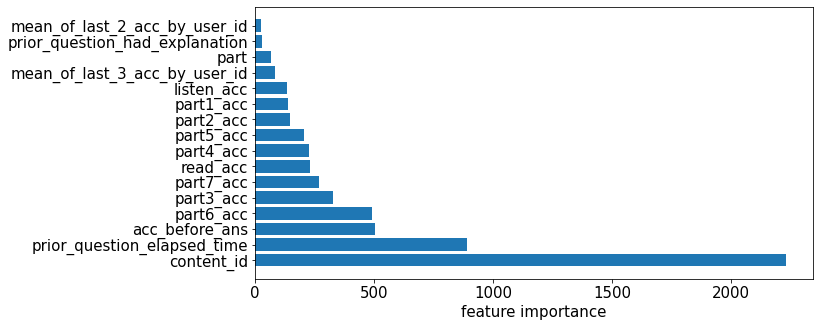

In [13]:
plt.rcParams.update({'font.size': 15})
x = list(feature_importance_df["Feature"].values)
y = feature_importance_df["Average"].values

x_position = np.arange(len(x))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 1, 1)
ax.barh(x_position, y, tick_label=x)
ax.set_xlabel('feature importance')
plt.show()

# prediction

In [14]:
del train

In [15]:
env = riiideducation.make_env()
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
    y_preds = []
    test_df = test_df.merge(questions[["question_id", "part"]], how="left", left_on=['content_id'], right_on=['question_id'])
    test_df.drop(["question_id"], axis=1, inplace=True)

    test_df['prior_question_had_explanation'] = test_df['prior_question_had_explanation'].fillna(value = False).astype(bool)
    test_df = get_data(test_df, test_set=True)
    test_df["prior_question_had_explanation"] = le.fit_transform(test_df["prior_question_had_explanation"])

    for model in models:
        y_pred = model.predict(test_df[columns], num_iteration=model.best_iteration)
        y_preds.append(y_pred)

    y_preds = sum(y_preds) / len(y_preds)
    test_df['answered_correctly'] = y_preds
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])